In [1]:
%matplotlib inline
import matplotlib.pyplot as plt;import seaborn as sns
import numpy as np;import pandas as pd

### 2.3 天气预测问题

#### 一. 数据来源与分析目的
1. 预测24小时后的天气
2. 数据集来源 :   
 [https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)
3. 数据结构  
 记录了从2009年到2016年间, 每十分钟统计一次14个指标 (天气,起亚,湿度,风向等), 用这些数据来预测24小时候的天气

#### 二. 数据初步探查

In [2]:
#### 1. 查看数据
import os
data_dir = '/home/lj/data/Deelearning_with_python'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')

data = pd.read_csv(fname,index_col='Date Time')
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


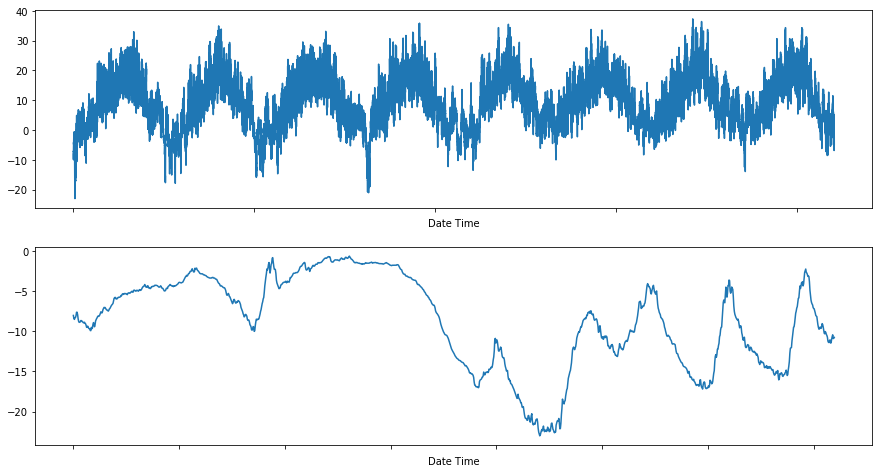

In [3]:
f,axes = plt.subplots(2,1,figsize=(15,8))
#全部气温的时序图
data['T (degC)'].plot(ax=axes[0])
# 前10天的气温时序图 : 因为每10分钟统计一次, 每天统计24*6次
data['T (degC)'].iloc[:10*24*6].plot(ax=axes[1])

#### 三. 准备数据生成器  
1. 选择前200,000条数据作为训练集
2. 数据需要正则化: 因为14个指标的取值范围相差较大  
3. 因为属于每十分钟统计一次, 数据密度太大.造成数据大量冗余.   
 我们改为每小时作为时间步长, 前10天的数据作为时间序列的样本, 来预测1天之后的温度   

In [4]:
###２. 正则化数据
test_data = data[:200000]
float_data = test_data.values.astype(np.float64)
print float_data[0,:]
mean = float_data.mean(axis=0)
float_data -= mean
std = float_data.std(axis=0)
float_data /= std
print float_data.shape

[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]
(200000, 14)


In [5]:
float_data[0,:]

array([ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
       -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
        2.12375056, -0.72950452, -0.78067973, -0.27613603])

In [6]:
# 3. 生成Generator对象
lookback = 10*24*6  # 10天
delay = 1*24*6          # 1天
account_step = 6          # 统计步长1小时
def generator(data,min_index,max_index,shuffle=False,batch_size=32,lookback=lookback,delay=delay,account_step=account_step):
    while 1 : 
            if shuffle:
                start_samples  = np.random.randint(min_index , max_index-lookback, size=batch_size)
            else : 
                start_samples = np.arange(min_index, min_index+account_step*batch_size, account_step)

            samples = np.zeros((batch_size, lookback//account_step, data.shape[-1]))
            targets = np.zeros(batch_size)
            
            # [注] : 列表在进行enumerate后, 才能变成(index,value)的键值对集合
            for i,sample_start in enumerate(start_samples):
                time_steps = range(sample_start, sample_start+lookback, account_step)
                samples[i] = float_data[time_steps,:]
                targets[i] = float_data[time_steps[-1] + delay,1]

            yield samples,targets

In [7]:
train_gen = generator(float_data,min_index=0,max_index=100000,shuffle=True)
val_gen = generator(float_data,min_index=100001,max_index=105000,shuffle=True)
test_gen = generator(float_data,min_index=105001,max_index=110000,shuffle=True)

val_step = 105000 -100001- lookback
test_steps = 110000 - 105001 - lookback
print val_step,test_steps

3559 3559


#### 四. 为待解决的问题就案例基准线
1. 在使用RNN进行数据训练之前, 需要对该问题建立一个评判好坏的基准线.   
 比如, 一个分类问题, 如果正例有90%, 负例有10%. 则如果全部预测正例, 准确李为90%. 此时, 一切解决问题的机器学习算法, 正确表现都应该超过90%  
2. 2种基准线方法  :  
  1. 不使用任何机器学习算法  
   将时间序列最后一个时间步的'温度'属性输入值, 作为下一天'温度'的预测值, 观察其平均绝对误差  MAE
  2. 使用简单的2层神经网络, 训练数据. 观察其MAE  
    1. 将3D的时间序列数据展成2D : (samples , timestep, features) -> (samples, concate all timestep features)  
    2. 最后一层网络没有激活函数, 因为是回归问题

In [27]:
####################  1. 不使用任何算法解决问题
generator1 = generator(float_data,min_index=0,max_index=100000)

def evaluate_naive_perfoemance(): 
    batch_matches = []
    for  i in range (10000):
        samples,targets = generator1.next()
        preds = samples[:,-1,1]  # 最后一个时间步的温度属性
#         print preds
#         print targets
        mae = np.mean(np.abs(preds-targets))
        batch_matches.append(mae)
    return np.mean(batch_matches)

mae = evaluate_naive_perfoemance()
print 'naive performance: ', mae
print 'naive performance: ', mae * std[1] ,'摄氏度'

naive performance:  0.39388594877229016
naive performance:  3.4868750000000004 摄氏度


In [25]:
####################  2. 使用简单的2层全连接神经网络预测
from keras.models import Sequential
from keras.layers import Dense,Flatten

model = Sequential()
model.add(Flatten(input_shape=(lookback//account_step,float_data.shape[-1])))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='rmsprop',loss='mae')
history = model.fit_generator(generator1,
                   steps_per_epoch = 500,  # 生成器返回多少次算是一个epoch
                   epochs=10,      # epoch数
                   validation_data = val_gen,  #  验证集生成器
                   validation_steps = val_step)      # 验证集返回轮数 

Epoch 1/10
500/500 [==============================] - 9s 17ms/step - loss: 0.1941 - val_loss: 0.5240
Epoch 2/10
500/500 [==============================] - 8s 17ms/step - loss: 0.0976 - val_loss: 0.6248
Epoch 3/10
500/500 [==============================] - 8s 17ms/step - loss: 0.0896 - val_loss: 0.6448
Epoch 4/10
500/500 [==============================] - 8s 16ms/step - loss: 0.0860 - val_loss: 0.5585
Epoch 5/10
500/500 [==============================] - 8s 16ms/step - loss: 0.0840 - val_loss: 0.5954
Epoch 6/10
500/500 [==============================] - 9s 17ms/step - loss: 0.0832 - val_loss: 0.5119
Epoch 7/10
500/500 [==============================] - 9s 17ms/step - loss: 0.0831 - val_loss: 0.5621
Epoch 8/10
500/500 [==============================] - 8s 17ms/step - loss: 0.0817 - val_loss: 0.5312
Epoch 9/10
500/500 [==============================] - 8s 17ms/step - loss: 0.0822 - val_loss: 0.5985
Epoch 10/10
500/500 [==============================] - 8s 17ms/step - loss: 0.0810 - val_lo

#### 五. RNN处理
1.  使用GRU单元进行RNN  
 GRU表现力不如LSTM, 但是计算消耗却小很多, 这是一种表现力和计算时间的折中
2. 使用dropout泛化  
  1. dropout : 每层输入单元的失效率
  2. recurrent_dropout : RNN单元的失效率  
3. 堆叠RNN层  
 因为RNN单元的输入是3D张量, 所以要想堆叠成功, 必须让上个RNN层的输出也是3D的, 即每个时间步都有输出, 设置参数`return_sequences=True`

In [9]:
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers import GRU
model = Sequential()
model.add(GRU(32,
              dropout=0.1,  # 失效率
              recurrent_dropout=0.5,  # 失效率
              return_sequences=True,  # 每个时间步都有输出
              input_shape=(None,float_data.shape[-1])))
model.add(GRU(64,dropout=0.1,recurrent_dropout=0.5))
model.add(Dense(1))

model.compile(optimizer='rmsprop',loss='mae')
history = model.fit_generator(train_gen,
                   steps_per_epoch = 500,  # 生成器返回多少次算是一个epoch
                   epochs=10,      # epoch数
                   validation_data = val_gen,  #  验证集生成器
                   validation_steps = val_step)      # 验证集返回轮数 

/devkit/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/10
500/500 [==============================] - 596s 1s/step - loss: 0.3252 - val_loss: 0.3621
Epoch 2/10
500/500 [==============================] - 591s 1s/step - loss: 0.3056 - val_loss: 0.3230
Epoch 3/10
500/500 [==============================] - 583s 1s/step - loss: 0.2956 - val_loss: 0.3202
Epoch 4/10
500/500 [==============================] - 582s 1s/step - loss: 0.2935 - val_loss: 0.3337
Epoch 5/10
500/500 [==============================] - 600s 1s/step - loss: 0.2854 - val_loss: 0.3257
Epoch 6/10
500/500 [==============================] - 586s 1s/step - loss: 0.2866 - val_loss: 0.3542
Epoch 7/10
500/500 [==============================] - 583s 1s/step - loss: 0.2796 - val_loss: 0.3510
Epoch 8/10
500/500 [==============================] - 601s 1s/step - loss: 0.2808 - val_loss: 0.3417
Epoch 9/10
500/500 [==============================] - 604s 1s/step - loss: 0.2789 - val_loss: 0.3385
Epoch 10/10
500/500 [==============================] - 609s 1s/step - loss: 0.2749 - val_lo

#### 六. 双向RNN
1. 双向RNN, 在RNN单元外部使用`layers.Bidirectional(LSTM(32))`包装

### 2.4 [附录] python中的Generator
#### 1. 列表迭代器  
 列表生成器, 使用`[]`生成列表, 且一次性装入内存. 为了避免大数据集下内存装不开, 使用类似迭代器的概念, 这里叫`生成器`.   
 生成器产生方法 : 使用`()`生成`列表的Generator`. next()方法获取当前index下的值

In [81]:
gen1 = (x*x for x in range(3))
# 第4次迭代时, 超出列表生成器的范围, 报错'StopIteration'
for i in range(4):
    print '第',i,'次执行: ',gen1.next()

第 0 次执行:  0
第 1 次执行:  1
第 2 次执行:  4
第 3 次执行: 

StopIteration: 

#### 2. 包含yeild关键字的方法  
1. 包含关键字yield的方法不再是一个函数, 而是一个Generator对象. 可以像列表Generator一样进行迭代  
2. 包含关键字yield的方法, 在遇到yield时, 会立即退出(相当于return), 并返回yield后面的值, 并记住这个返回位置. 下一次调用`next`方法时, 继续从该位置执行方法 
3. Generator对象可使用for进行迭代

In [82]:
# 生成器函数
def test_yield(n):
    for i in range(n):
        yield(i*i)
    print 'test_field finish !'
    
# 迭代生成器     
for i in test_yield(5):
    print i

 0
1
4
9
16
test_field finish !


#### 3. send(msg)与next()取值

1. send(msg)与next()的区别在于send可以传递参数给yield表达式，这时传递的参数会作为yield表达式的值，而yield的参数是返回给调用者的值。  
 ——换句话说，就是send可以强行修改上一个yield表达式值。比如函数中有一个yield赋值，a = yield 5，第一次迭代到这里会返回5，a还没有赋值。第二次迭代时，使用.send(10)，那么，就是强行修改yield 5表达式的值为10，本来是5的，那么a=10
 
1. yield返回给调用者其与面的值, 但是yield表达式本身没有返回值.   
 比如 : 方法内部有语句 : `a = yield 5`. 这句话返回给调用者5, 但是a并没有赋值. 除非调用者使用send(msg), 才能把a赋值成msg

In [122]:
def test_yield2():
    a = yield 5
    print 'a: ',a
    
    b = 5 + a
    print 'b: ', b
    print 'finish !'
    yield 1
    
generator = test_yield2()    
print generator.next()
print '====================='
# 下面没有使用send(msg)调用, 导致方法内b没有被赋值
# generator.next()
print generator.send(100)

5
a:  100
b:  105
finish !
1


In [153]:
for a,b in enumerate([1,2,3,4]):
    print a,b

0 1
1 2
2 3
3 4
